In [ ]:
!pip install langgraph langchain_ollama

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
from langchain_ollama import ChatOllama

## Define the State

In [2]:
class ReviewState(TypedDict):
    raw_reviews: List[str]
    processed_text: str
    summary: str
    sentiment: str
    final_output: dict

## Define Large Language Model

In [3]:
llm = ChatOllama(
    model="gpt-oss:20b",
    validate_model_on_init=True,
    temperature=0.3,
    num_predict=256,
)

In [4]:
llm.invoke("hello")

AIMessage(content='Hello! 👋 How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-10-07T09:58:07.076239Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6496048250, 'load_duration': 117963292, 'prompt_eval_count': 68, 'prompt_eval_duration': 4966768625, 'eval_count': 47, 'eval_duration': 1410490834, 'model_name': 'gpt-oss:20b'}, id='run--a65a5e7b-8a25-4753-b702-d4cd2e0b44bb-0', usage_metadata={'input_tokens': 68, 'output_tokens': 47, 'total_tokens': 115})

## Define nodes

In [5]:
def preprocessor_agent(state: ReviewState):
    """Agent 1: Preprocess the reviews."""
    print("- Preprocessing reviews...")
    text = "\n".join(state["raw_reviews"])
    return {"processed_text": f"Customer reviews:\n{text}"}

def summary_agent(state: ReviewState):
    """Agent 2: Generate summary."""
    print("- Generating summary...")
    prompt = f"Summarize these reviews briefly:\n{state['processed_text']}\nSummary: "
    response = llm.invoke(prompt)
    return {"summary": response.content}

def sentiment_agent(state: ReviewState):
    """Agent 3: Perform sentiment analysis."""
    print("- Analyzing sentiment...")
    prompt = f"Classify overall sentiment to one of these Positive, Negative, Neutral:\n{state['processed_text']}\nSentiment: "
    response = llm.invoke(prompt)
    return {"sentiment": response.content}

def output_parser(state: ReviewState):
    """Final combiner node."""
    print("- Combining outputs...")
    final = {
        "summary": state["summary"],
        "sentiment": state["sentiment"]
    }
    return {"final_output": final}

## Build the graph

In [6]:
builder = StateGraph(ReviewState)

# Add nodes:
builder.add_node("preprocessor", preprocessor_agent)
builder.add_node("summary", summary_agent)
builder.add_node("sentiment", sentiment_agent)
builder.add_node("parser", output_parser)

# Flow:
# START → preprocessor  
builder.add_edge(START, "preprocessor")
# preprocessor → summary  
builder.add_edge("preprocessor", "summary")
# preprocessor → sentiment  
builder.add_edge("preprocessor", "sentiment")
# summary → parser
builder.add_edge("summary", "parser")
# sentiment → parser  
builder.add_edge("sentiment", "parser")
# parser → END
builder.add_edge("parser", END)

### Compile the graph

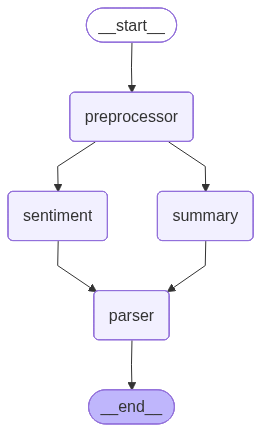

In [7]:
from IPython.display import Image, display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Run it

In [8]:
initial_state = {
    "raw_reviews": [
        "Battery lasts two days, excellent performance.",
        "Camera is great but the phone is heavy.",
        "Very satisfied with the purchase overall."
    ]
}

result = graph.invoke(initial_state)

- Preprocessing reviews...
- Analyzing sentiment...
- Generating summary...
- Combining outputs...


In [9]:
import json
print("Final structured output:", json.dumps(result["final_output"], indent=2))

Final structured output: {
  "summary": "The phone delivers strong battery life and solid performance, a good camera, though it\u2019s a bit heavy, and overall users are very satisfied.",
  "sentiment": "Positive"
}
